1.Data selection and preprocessing

1st step : selection and separation of data

-> In order to represent all the 7 classes, we are going to select the maximum out of the less represented ones 

In march 2024, the available data consists of this : 

Plastique 22996
Mégots 2827
Papier ou Carton 9061
Textile 1446
Métaux 13424
Verre 4709
Matières Organiques 338

For the first experiments, we selected up to 2000 images of each class (not randomly, see select_data from data_processing)

Starting from a raw file, we select the filenames we want the model to train on


-> We load this images and sort it into different folders this way : 

data/
    -Verre/
        --Verre01
        --Verre02
        ...
    -Mégots/
        --Mégots01
        --Mégots02
        ...
    ...

-> Then we separate it into train, test and split

In [1]:
DATASET_PATH = '../../../../Trashback2000_620v2'
excel_path = '/Users/macbook/Desktop/waste_pics.xlsx'

In [2]:
raw_data_path = "/Users/macbook/Desktop/Trashback" # the full quality images
size=(620,620)
output_folder = '/Users/macbook/Desktop/Trashback_resized_resnet'

In [3]:
from data_processing import import_excel_from_local, create_dictionnaries

excel_data = import_excel_from_local(excel_path)

In [4]:
excel_data.head()

,CREATED,PIC_NAME,WASTE_TYPE,WASTE_SUB_TYPE
0,2023-07-18 02:41:23,1689655283310-image1689655288912.jpg,Plastique,Bouteille en plastique
1,2023-07-18 03:03:52,1689656632003-image1689656604097.jpg,Mégots,Mégots
2,2023-07-18 03:04:23,1689656663316-image1689656670630.jpg,Papier ou Carton,Récipient liquide
3,2023-07-18 03:07:22,1689656842073-image1689656841084.jpg,Mégots,Mégots
4,2023-07-18 03:10:33,1689657033386-image1689657030920.jpg,Plastique,Polystyrène


In [5]:
category_files,image_labels,image_sub_labels = create_dictionnaries(excel_data)

In [6]:
#we can also directly import the dictionnaries

import json
import shutil

with open('category_files.json', 'r') as fp:
        category_files = json.load(fp)

In [7]:
for category in category_files.keys():
    print(category,len(category_files[category]))

Plastique 2000
Mégots 2000
Papier ou Carton 2000
Textile 1446
Métaux 2000
Verre 2000
Matières Organiques 338


In [8]:
from data_processing import data_selection

In [9]:

category_files = data_selection(2000,category_files) # this is not random !!
for category in category_files.keys():
    print(category,len(category_files[category]))

Plastique 2000
Mégots 2000
Papier ou Carton 2000
Textile 1446
Métaux 2000
Verre 2000
Matières Organiques 338


In [23]:
from data_resizing_pipeline import resize_images

filenames = []
for category in category_files.keys():
    filenames += category_files[category]

input_folder = raw_data_path

resize_images(input_folder, output_folder, size, filenames_to_resize = filenames)

resizing 11784 images


KeyboardInterrupt: 

Now we have our images (max 2000 per class) in our folder (output_folder)

In [16]:
from data_processing import sort_local_file


In [24]:
import importlib
import data_processing
importlib.reload(data_processing)

<module 'data_processing' from '/Users/macbook/Desktop/WasteScan/waste-scan/models/trashback/data_processing.py'>

In [27]:
from data_processing import sort_local_file

file_to_sort = '/Users/macbook/Desktop/Trashback_2000_620v2/'

sort_local_file(file_to_sort,category_files)  # choses à régler 

1491
1491 fichiers non trouvés dans le dicitonnaire, tri réalisé pour les autres


In [31]:
from train_resnet import make_train_valid_test_data
DATASET_PATH = file_to_sort
train_data,valid_data,test_data = make_train_valid_test_data(DATASET_PATH,size=(620,620))

there is 8475 images for training
there is 2354 images for testing


In [32]:
from train_resnet import make_loader

train_loader = make_loader(train_data, batch_size=10, shuffle=True)
val_loader = make_loader(valid_data, batch_size=10)
test_loader = make_loader(test_data, batch_size=10)

Now everything is ready for training, we can show some images

In [35]:
import matplotlib.pyplot as plt

def show_image(image, label):
    plt.title(f"label: {label}, {LABELS[label]}\n")
    plt.imshow(transforms.ToPILImage()(image).convert('RGB'))


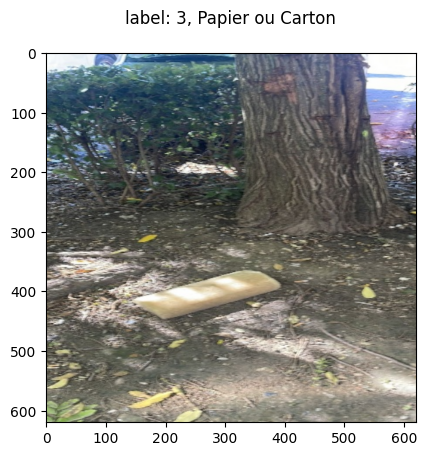

In [40]:
import torchvision
from torchvision import transforms
train_dataset = torchvision.datasets.ImageFolder(DATASET_PATH)
LABELS=train_dataset.classes

image, label = train_data[0]
show_image(image, label)

2. Now the training 

In [41]:
print(train_dataset.class_to_idx)

{'Matières Organiques': 0, 'Mégots': 1, 'Métaux': 2, 'Papier ou Carton': 3, 'Plastique': 4, 'Textile': 5, 'Verre': 6}


In [43]:
LABELS = train_dataset.classes
num_class = len(LABELS)


from train_resnet import create_model,train

models = ['Resnet','Resnext']

model = create_model(num_class,model_type=models[1])


trainer = train(train_loader,val_loader,model,max_epochs=25, limit_train_batches=100,default_root_dir='./logs/resnxet')


/Users/macbook/Desktop/WasteScan/waste-scan/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /Users/macbook/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)>

Now we can evaluate the model on the test set



In [44]:
from test_resnet import test,print_confusion_matrix

test(trainer,model,test_loader,ckpt_path='best')

NameError: name 'trainer' is not defined

In [ ]:
path_to_checkpoints = 

print_confusion_matrix(path_to_checkpoints)